In [89]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.cluster import KMeans
glob_temp = np.arange(-0.2,6.8,0.1)

In [90]:
import oggm
from oggm import utils

In [135]:
df_rgi6g = pd.read_hdf(utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))
df_rgi6g = df_rgi6g.loc[df_rgi6g.Connect != 2]

df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
rgidf_dict = {}
rgidf_vol = {}
rgidf_vol_all = 0
slope_avg_d = {}
rgi_regs = list(df_rgi6g['O1Region'].unique())
for rgi_reg in rgi_regs:
    rgidf = df_rgi6g.loc[df_rgi6g.O1Region == rgi_reg]
    # Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    if rgi_reg == '05':
        rgidf = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
    rgidf_dict[rgi_reg] = rgidf
    
    rgidf_vol[rgi_reg] = df_itmix.loc[rgidf_dict[rgi_reg].index]['vol_itmix_m3'].sum()
    rgidf_vol_all += df_itmix.loc[rgidf_dict[rgi_reg].index]['vol_itmix_m3'].sum()
    slope_avg = np.average(rgidf['Slope'], weights=df_itmix.loc[rgidf_dict[rgi_reg].index]['vol_itmix_m3'].values)
    slope_avg_d[rgi_reg] = slope_avg
pd_rel_vol = (100*pd.DataFrame(index=['vol_relperc_itmix'],data=rgidf_vol)/rgidf_vol_all).T
np.testing.assert_allclose(pd_rel_vol.sum(), 100)

In [21]:
# add = ''
add= '_temp_above_0_8'

#pd_exp_decay_fits_adv = pd.read_csv(f'fitted_glacier_response_to_global_temp_ch_complex_20yr_avg_period{add}.csv', index_col=0)
pd_exp_decay_fits_simple = pd.read_csv(f'fitted_glacier_response_to_global_temp_ch_simple_20yr_avg_period{add}_current12deg.csv', index_col=0)

In [4]:
pd_exp_decay_fits_simple_5000 = pd_exp_decay_fits_simple.loc[pd_exp_decay_fits_simple.year ==5000]


In [5]:
df = pd_exp_decay_fits_simple_5000.copy()

In [6]:
def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    #print(_p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc'))
    _p = _p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc')
    return _p
glob_temp_ch = get_glob_temp_exp(region='global')['temp_ch_ipcc'].values
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler

colors_icci_l3 = ['#70B8FF', '#FABB00', '#F25100', '#D42300', '#B3001E', '#800040', '#550066', '#2B084D']
cmap_icci_3 = LinearSegmentedColormap.from_list('bins_100', colors_icci_l3, N=1000)
scaler = MinMaxScaler()
temp_ch_sel = np.arange(0.75,glob_temp_ch.max(),0.25)
scaler.fit(temp_ch_sel.reshape(-1,1))
cmap = cmap_icci_3

In [7]:
current_deltaT = 1.2
def exponential_decay(x, a, b):
    exp_values_b = -b *(x-current_deltaT)
    return a * np.exp(exp_values_b) #+ c * np.exp(exp_values_d)#**c 

In [8]:
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

In [9]:
rgi_shp_fn = 'figures_data_worldmap/rgi60_all_simplified2_robinson.shp'
rgi_regions_fn = 'figures_data_worldmap/rgi60_regions_robinson-v2.shp'

In [286]:
def reg_pie_subplot(reg = 'All', ax =None, leg = False):
    shift = 0.5*np.pi

    pd_sel_reg = df.loc[df.rgi_reg==reg]
    a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
    rot_l = []
    t_l = []
    temp_ch_sel_n = np.arange(1.2,glob_temp_ch.max(),0.05)
    colors_fit_n = cmap(scaler.transform(temp_ch_sel_n.reshape(-1,1))) # only every decile ... 
    for t,c in zip(temp_ch_sel_n, colors_fit_n):

        f = exponential_decay(t,a,b)
        valsnorm = (1-((f/100)))*2*np.pi  #+shift

        c=cmap(scaler.transform(t.reshape(-1,1)))
        ax.vlines(x=-valsnorm+shift, ymin=0.2,ymax=0.45, color = c, lw=0.5, alpha = 0.5)
        if t.round(2) in [1.5,2,2.5, 3,3.5,4,4.5, 5]:
            size=0.17
            ax.vlines(x=-valsnorm+shift, ymin=0.2,ymax=0.47, color = c, lw=2, zorder=5)
            rot_l.append(-valsnorm+shift)
            t_l.append(t)
        if t.round(2) in [1.2]:
            ax.bar(x=shift,#valsleft[-1], #[:, 0],
                        width=[0,-valsnorm], #+shift, #10, #valsnorm.sum(axis=1),
                        bottom=0.2, height=0.25,
                        color='darkgrey', edgecolor='w', linewidth=2, align="edge", alpha =1)
        
        if t.round(2) in [1.2,1.5,2,2.5,3] and reg == 'All' and leg:
            if t.round(2) == 1.2:
                tt = f'{t.round(1)}°C'
            else:
                tt = f'{t.round(1)}'
            ax.text(-valsnorm+shift, 0.475, tt, fontsize=8,
                    fontweight='bold',
                    color=c.squeeze(), verticalalignment='top') #, horizontalalignment='center')
    #ax.invert_xaxis()
    #ax.vlines(shift, color='grey',ymin=0.18,ymax=0.5, lw=1, ls='--', zorder=10)
    #ax.vlines(0, color='grey',ymin=0.18,ymax=0.5, lw=0.5, ls=':', zorder=10)
    #ax.vlines(-shift, color='grey',ymin=0.18,ymax=0.5, lw=0.5, ls=':', zorder=10)

    if reg == 'All' and leg:
        ax.set_title('Steady-state loss', fontsize=10)
    ax.set_ylim([0,0.47])
        
    #ax.axis("off")   # turns off axes
    ax.get_xaxis().set_visible(False)
    ax.set_facecolor('whitesmoke')
    #ax.set_axisbelow.set_visible(False)
    ax.grid(False)
    #ax.set_xticklabels(['25%', '50%','75%', '100%'])
    #ax.set_xticks(ticks = rot_l,labels=t_l)
    ax.set_yticks([])#.set_visible(False)


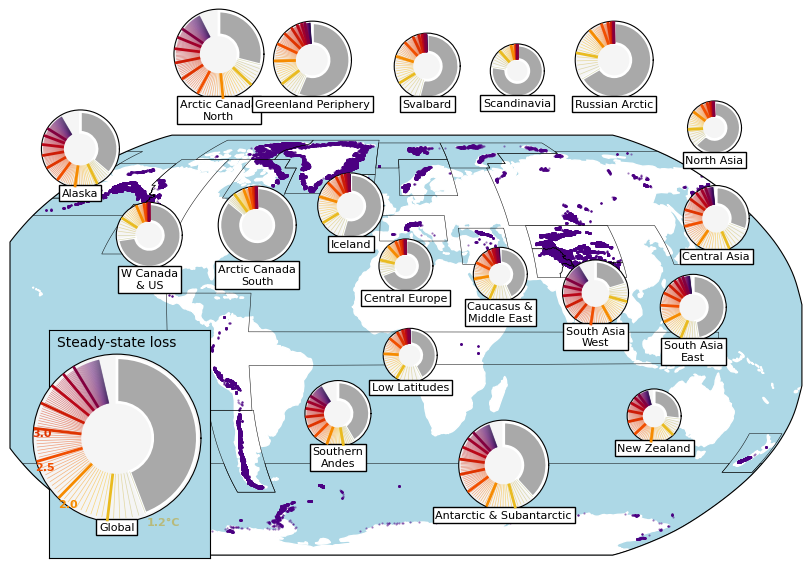

In [289]:
#%% ----- FIGURE: GLOBAL COMBINED -----
add_rgi_glaciers = True
add_rgi_regions = True

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Note that I'm ignoring clipping and other edge cases here.
        result, is_scalar = self.process_value(value)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)

rgi_reg_fig_dict = {'All':'Global',
                    '01':'Alaska',
                    '02':'W Canada\n& US',
                    '03':'Arctic Canada\nNorth',
                    '04':'Arctic Canada\nSouth',
                    '05':'Greenland Periphery',
                    '06':'Iceland',
                    '07':'Svalbard',
                    '08':'Scandinavia',
                    '09':'Russian Arctic',
                    '10':'North Asia',
                    '11':'Central Europe',
                    '12':'Caucasus &\nMiddle East',
                    '13':'Central Asia',
                    '14':'South Asia\nWest',
                    '15':'South Asia\nEast',
                    '16':'Low Latitudes',
                    '17':'Southern\nAndes',
                    '18':'New Zealand',
                    '19':'Antarctic & Subantarctic'
                    }

pie_scenarios = [2]
for pie_scenario in pie_scenarios:

    fig = plt.figure() #(figsize=(16,10))

    # Add background image
    ax_background = fig.add_axes([0,0.15,1,0.7], projection=ccrs.Robinson())
    ax_background.patch.set_facecolor('lightblue')
    ax_background.get_yaxis().set_visible(False)
    ax_background.get_xaxis().set_visible(False)
#    ax_background.coastlines(color='white')
    ax_background.add_feature(cartopy.feature.LAND, color='white')

    # Add global boundary
    ax_global_patch = fig.add_axes([0.08,0.145,0.19,0.38], facecolor='lightblue')
    ax_global_patch.get_yaxis().set_visible(False)
    ax_global_patch.get_xaxis().set_visible(False)

    # Add RGI glacier outlines
    if add_rgi_glaciers:
        # if I do that here: 
        # **somehow only the glaicers of one RGI region are visible**
        #shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='indigo',linewidth=0.35,edgecolor='indigo')
        #ax_background.add_feature(shape_feature)
        # instead aplly that here ... 
        ax_background.scatter(df_rgi6g.CenLon.values, df_rgi6g.CenLat.values, color='indigo', s=0.3, alpha =0.5,
                          transform=ccrs.PlateCarree());
    if add_rgi_regions:
        shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(),
                                       ccrs.Robinson(),alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
        ax_background.add_feature(shape_feature)


    regions_ordered = list(rgi_reg_fig_dict.keys())
    reg_pie_sizes = []
    
    for reg in regions_ordered:
        #reg_slr_cum_pie = stats_overview_df.loc[(stats_overview_df.Region==reg) & (stats_overview_df.Scenario==pie_scenario),'slr_mmSLE_med'].values[0]
        #print(reg, np.round(reg_slr_cum_pie,2))
        #pie_size_min = 0.07
        #if reg_slr_cum_pie > 80:
        #    pie_size = 0.33
        #elif reg_slr_cum_pie > 25:
        #    pie_size = 0.2
        #elif reg_slr_cum_pie < 1:
        #    pie_size = pie_size_min
        #else:
        #    pie_size = pie_size_min + (reg_slr_cum_pie - 1) / (25-1) * (0.2 - pie_size_min)
        if reg == 'All':
            pie_size=0.28
        else:
            if pd_rel_vol.loc[reg].values > 15:
                pie_size=0.15
            elif pd_rel_vol.loc[reg].values > 5:
                pie_size=0.13
            elif pd_rel_vol.loc[reg].values > 0.5:
                pie_size=0.11
            else:
                pie_size=0.09

        reg_pie_sizes.append(pie_size)
    
    add_horizontal_bar = False
    if add_horizontal_bar:
        ax0 = fig.add_axes([0.125,0.18,0.1,0.04], facecolor='none')
        ax1 = fig.add_axes([0.09,0.73,0.1,0.04], facecolor='none')
        ax2 = fig.add_axes([0.13,0.59,0.1,0.04], facecolor='none')
        ax3 = fig.add_axes([0.21,0.875,0.1,0.04], facecolor='none')
        ax4 = fig.add_axes([0.265,0.60,0.1,0.04], facecolor='none')
        ax5 = fig.add_axes([0.34,0.875,0.1,0.04], facecolor='none')
        ax6 = fig.add_axes([0.37,0.64,0.1,0.04], facecolor='none')
        ax7 = fig.add_axes([0.465,0.875,0.1,0.04], facecolor='none')
        ax8 = fig.add_axes([0.573,0.875,0.1,0.04], facecolor='none')
        ax9 = fig.add_axes([0.68,0.875,0.1,0.04], facecolor='none')
        ax10 = fig.add_axes([0.8,0.78,0.1,0.04], facecolor='none')
        ax11 = fig.add_axes([0.44,0.55,0.1,0.04], facecolor='none')
        ax12 = fig.add_axes([0.55,0.535,0.1,0.04], facecolor='none')
        ax13 = fig.add_axes([0.8,0.62,0.1,0.04], facecolor='none')
        ax14 = fig.add_axes([0.655,0.495,0.1,0.04], facecolor='none')
        ax15 = fig.add_axes([0.77,0.47,0.1,0.04], facecolor='none')
        ax16 = fig.add_axes([0.445,0.40,0.1,0.04], facecolor='none')
        ax17 = fig.add_axes([0.36,0.295,0.1,0.04], facecolor='none')
        ax18 = fig.add_axes([0.73,0.3,0.1,0.04], facecolor='none')
        ax19 = fig.add_axes([0.55,0.19,0.1,0.04], facecolor='none')

    # Pie charts
    ax0b = fig.add_axes([0.01+0.01,0.205,reg_pie_sizes[0],reg_pie_sizes[0]], facecolor='none',projection="polar")
    ax1b = fig.add_axes([0.052,0.762,reg_pie_sizes[1],reg_pie_sizes[1]], facecolor='none',projection="polar")
    ax2b = fig.add_axes([0.143,0.628,reg_pie_sizes[2],reg_pie_sizes[2]], facecolor='none',projection="polar")
    ax3b = fig.add_axes([0.205,0.91,reg_pie_sizes[3],reg_pie_sizes[3]], facecolor='none',projection="polar")
    ax4b = fig.add_axes([0.26,0.635,reg_pie_sizes[4],reg_pie_sizes[4]], facecolor='none',projection="polar")
    ax5b = fig.add_axes([0.325,0.91,reg_pie_sizes[5],reg_pie_sizes[5]], facecolor='none',projection="polar")
    ax6b = fig.add_axes([0.38,0.677,reg_pie_sizes[6],reg_pie_sizes[6]], facecolor='none',projection="polar")
    ax7b = fig.add_axes([0.47,0.91,reg_pie_sizes[7],reg_pie_sizes[7]], facecolor='none',projection="polar")
    ax8b = fig.add_axes([0.586,0.912,reg_pie_sizes[8],reg_pie_sizes[8]], facecolor='none',projection="polar")
    ax9b = fig.add_axes([0.68,0.91,reg_pie_sizes[9],reg_pie_sizes[9]], facecolor='none',projection="polar")
    ax10b = fig.add_axes([0.818,0.817,reg_pie_sizes[10],reg_pie_sizes[10]], facecolor='none',projection="polar")
    ax11b = fig.add_axes([0.455,0.587,reg_pie_sizes[11],reg_pie_sizes[11]], facecolor='none',projection="polar")
    ax12b = fig.add_axes([0.566,0.573,reg_pie_sizes[12],reg_pie_sizes[12]], facecolor='none',projection="polar")
    ax13b = fig.add_axes([0.81,0.656,reg_pie_sizes[13],reg_pie_sizes[13]], facecolor='none',projection="polar")
    ax14b = fig.add_axes([0.668,0.532,reg_pie_sizes[14],reg_pie_sizes[14]], facecolor='none',projection="polar")
    ax15b = fig.add_axes([0.783,0.508,reg_pie_sizes[15],reg_pie_sizes[15]], facecolor='none',projection="polar")
    ax16b = fig.add_axes([0.46,0.438,reg_pie_sizes[16],reg_pie_sizes[16]], facecolor='none',projection="polar")
    ax17b = fig.add_axes([0.365,0.331,reg_pie_sizes[17],reg_pie_sizes[17]], facecolor='none',projection="polar")
    ax18b = fig.add_axes([0.747,0.337,reg_pie_sizes[18],reg_pie_sizes[18]], facecolor='none',projection="polar")
    ax19b = fig.add_axes([0.54,0.225,reg_pie_sizes[19],reg_pie_sizes[19]], facecolor='none',projection="polar")
    
    
    # ----- Pie Chart of Volume Remaining at stead-state -----
    for nax, ax in enumerate([ax0b, ax1b, ax2b, ax3b, ax4b, ax5b, ax6b, ax7b, ax8b, ax9b, ax10b,
                              ax11b, ax12b, ax13b, ax14b, ax15b, ax16b, ax17b, ax18b, ax19b]):

        reg = regions_ordered[nax]

        reg_pie_subplot(reg=reg, ax=ax, leg=True)
        ax.text(0.5, 0, #-0.14,
                rgi_reg_fig_dict[reg], size=8, horizontalalignment='center', 
            verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='k', pad=2))
        #ax.axis('equal')   
#plt.tight_layout()
fig.set_size_inches(8.5,6)
plt.savefig('figures_data_worldmap/v0.png')

### VERSION B

In [271]:
temp_ch_sel_n = np.arange(0.75,glob_temp_ch.max(),0.01)
colors_fit_n = cmap(scaler.transform(temp_ch_sel_n.reshape(-1,1))) # only every decile ... 

def reg_pie_subplot_remaining_ice(reg = 'All', ax =None):
    shift = 0.5*np.pi

    extinct = False
    for yr in [100,5000]:

        df_yr = pd_exp_decay_fits_simple.loc[pd_exp_decay_fits_simple.year==yr]
        pd_sel_reg = df_yr.loc[df_yr.rgi_reg==reg]
        #pd_sel_reg = df.loc[df.rgi_reg==reg]
        a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
        if yr == 100:
            alpha = 0.8
            yr_w='grey'
            label_t = f'{yr} years'
            p=2
            width=0.17/2
            
        elif yr == 300:
            alpha = 0.8
            yr_w='lightgrey'
            label_t = f'{yr}'
            p=2
        else:
            yr_w='w'
            alpha = 0.8
            label_t = 'steady\nstate'
            width=0.165
            p=1
        size=0.17
        for t,c in zip(temp_ch_sel_n, colors_fit_n):
            f = exponential_decay(t,a,b)
            if (f<5) and (extinct==False) and (yr ==5000):
                if reg == 'All':
                    fs=6
                else:
                    fs =5
                ax.text(0, 0.04, f'<5%:\n{t.round(1)}°C', fontsize=6,
                        color=c.squeeze(), verticalalignment='center',horizontalalignment='center')
                extinct = True
            if t.round(2) in [1.2,1.5, 2, 2.5,3,3.5,4,4.5,5,5.5,6,6.5]:
                valsnorm = ((f/100))*2*np.pi  #+shift
                c=cmap(scaler.transform(t.reshape(-1,1)))
                c = c.squeeze()
                ax.bar(x=shift, 
                       width=[0,valsnorm], 
                       bottom=size*p, height=width,
                       color=c, edgecolor=yr_w, linewidth=0.5, align="edge", alpha = alpha)
                if yr == 5000:
                    pp = 0.08
                else:
                    pp = 0.04
                if t.round(2) in [1.2] and reg == 'All':
                    if label_t == 'steady\nstate':
                        ax.text(shift-0.05/p,size*p+pp,
                                label_t, fontsize=8,
                                color='grey', verticalalignment='center')
                    else:
                        ax.annotate(
                                label_t, xy=(shift-0.05/p,size*p+pp),
                            xytext=(shift-0.5,size*2+size/1.2),
                            arrowprops=dict(arrowstyle="->", lw=0.5),
                            fontsize=8,
                                color='grey', verticalalignment='center')
                if t.round(2) in [1.2,1.5,2,2.5, 3.5, 6.5] and p == 1 and reg == 'All':
                    if t.round(2) == 1.2:
                        tt=f'{t.round(1)}°C'
                        ha = 'left'
                    else:
                        tt = f'{t.round(1)}'
                        ha = 'center'
                    ax.text(valsnorm+shift, size-0.04, tt, fontsize=8,
                            color=c, verticalalignment='center', fontweight='bold', horizontalalignment=ha)

    ax.set_facecolor('silver')
    if reg == 'All':
        ax.set_title('Remaining ice\n(%, rel. to 2000)', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.set_facecolor('gainsboro')
    #ax.set_axisbelow.set_visible(False)
    ax.grid(False)
    ax.set_ylim([0,size*2+size/2])
    ax.set_yticks([])#.set_visible(False)

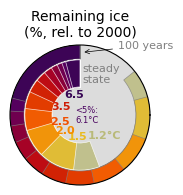

In [272]:
fig = plt.figure(figsize=(8,2))

ax = fig.add_axes([0,0.15,1,0.7], projection='polar')
reg_pie_subplot_remaining_ice(reg = 'All', ax=ax)

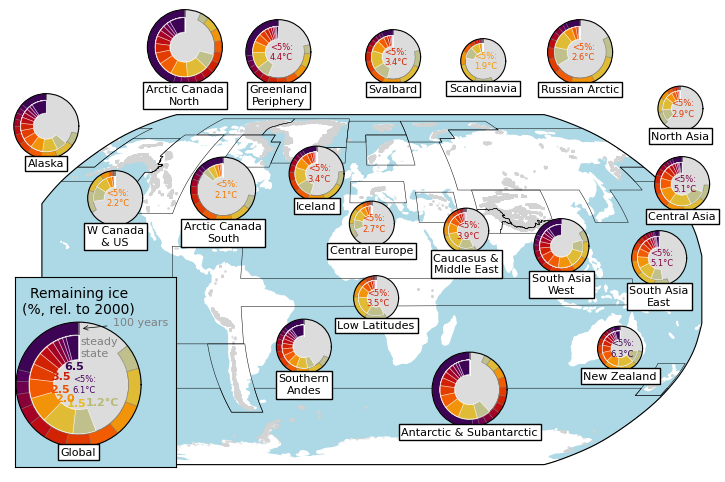

In [278]:
#%% ----- FIGURE: GLOBAL COMBINED -----
add_rgi_glaciers = True
add_rgi_regions = True

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Note that I'm ignoring clipping and other edge cases here.
        result, is_scalar = self.process_value(value)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)

rgi_reg_fig_dict = {'All':'Global',
                    '01':'Alaska',
                    '02':'W Canada\n& US',
                    '03':'Arctic Canada\nNorth',
                    '04':'Arctic Canada\nSouth',
                    '05':'Greenland\nPeriphery',
                    '06':'Iceland',
                    '07':'Svalbard',
                    '08':'Scandinavia',
                    '09':'Russian Arctic',
                    '10':'North Asia',
                    '11':'Central Europe',
                    '12':'Caucasus &\nMiddle East',
                    '13':'Central Asia',
                    '14':'South Asia\nWest',
                    '15':'South Asia\nEast',
                    '16':'Low Latitudes',
                    '17':'Southern\nAndes',
                    '18':'New Zealand',
                    '19':'Antarctic & Subantarctic'
                    }

pie_scenarios = [2]
for pie_scenario in pie_scenarios:

    fig = plt.figure() #figsize=(20,8))

    # Add background image
    ax_background = fig.add_axes([0,0.15,1,0.7], projection=ccrs.Robinson())
    ax_background.patch.set_facecolor('lightblue')
    ax_background.get_yaxis().set_visible(False)
    ax_background.get_xaxis().set_visible(False)
#    ax_background.coastlines(color='white')
    ax_background.add_feature(cartopy.feature.LAND, color='white')

    # Add global boundary
    ax_global_patch = fig.add_axes([0.08,0.145,0.19,0.38], facecolor='lightblue')
    ax_global_patch.get_yaxis().set_visible(False)
    ax_global_patch.get_xaxis().set_visible(False)

    # Add RGI glacier outlines
    if add_rgi_glaciers:
        # if I do that here: 
        # **somehow only the glaicers of one RGI region are visible**
        #shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='indigo',linewidth=0.35,edgecolor='indigo')
        #ax_background.add_feature(shape_feature)
        # instead aplly that here ... 
        ax_background.scatter(df_rgi6g.CenLon.values, df_rgi6g.CenLat.values, color='lightgrey', s=0.3, alpha =0.5,
                          transform=ccrs.PlateCarree());
    if add_rgi_regions:
        shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
        ax_background.add_feature(shape_feature)


    regions_ordered = list(rgi_reg_fig_dict.keys())
    reg_pie_sizes = []
    
    for reg in regions_ordered:
        #reg_slr_cum_pie = stats_overview_df.loc[(stats_overview_df.Region==reg) & (stats_overview_df.Scenario==pie_scenario),'slr_mmSLE_med'].values[0]
        #print(reg, np.round(reg_slr_cum_pie,2))
        #pie_size_min = 0.07
        #if reg_slr_cum_pie > 80:
        #    pie_size = 0.33
        #elif reg_slr_cum_pie > 25:
        #    pie_size = 0.2
        #elif reg_slr_cum_pie < 1:
        #    pie_size = pie_size_min
        #else:
        #    pie_size = pie_size_min + (reg_slr_cum_pie - 1) / (25-1) * (0.2 - pie_size_min)
        if reg == 'All':
            pie_size=0.25
        else:
            if pd_rel_vol.loc[reg].values > 15:
                pie_size=0.15
            elif pd_rel_vol.loc[reg].values > 5:
                pie_size=0.13
            elif pd_rel_vol.loc[reg].values > 0.5:
                pie_size=0.11
            else:
                pie_size=0.09

        reg_pie_sizes.append(pie_size)
    
    add_horizontal_bar = False
    if add_horizontal_bar:
        ax0 = fig.add_axes([0.125,0.18,0.1,0.04], facecolor='none')
        ax1 = fig.add_axes([0.09,0.73,0.1,0.04], facecolor='none')
        ax2 = fig.add_axes([0.13,0.59,0.1,0.04], facecolor='none')
        ax3 = fig.add_axes([0.21,0.875,0.1,0.04], facecolor='none')
        ax4 = fig.add_axes([0.265,0.60,0.1,0.04], facecolor='none')
        ax5 = fig.add_axes([0.34,0.875,0.1,0.04], facecolor='none')
        ax6 = fig.add_axes([0.37,0.64,0.1,0.04], facecolor='none')
        ax7 = fig.add_axes([0.465,0.875,0.1,0.04], facecolor='none')
        ax8 = fig.add_axes([0.573,0.875,0.1,0.04], facecolor='none')
        ax9 = fig.add_axes([0.68,0.875,0.1,0.04], facecolor='none')
        ax10 = fig.add_axes([0.8,0.78,0.1,0.04], facecolor='none')
        ax11 = fig.add_axes([0.44,0.55,0.1,0.04], facecolor='none')
        ax12 = fig.add_axes([0.55,0.535,0.1,0.04], facecolor='none')
        ax13 = fig.add_axes([0.8,0.62,0.1,0.04], facecolor='none')
        ax14 = fig.add_axes([0.655,0.495,0.1,0.04], facecolor='none')
        ax15 = fig.add_axes([0.77,0.47,0.1,0.04], facecolor='none')
        ax16 = fig.add_axes([0.445,0.40,0.1,0.04], facecolor='none')
        ax17 = fig.add_axes([0.36,0.295,0.1,0.04], facecolor='none')
        ax18 = fig.add_axes([0.73,0.3,0.1,0.04], facecolor='none')
        ax19 = fig.add_axes([0.55,0.19,0.1,0.04], facecolor='none')

    # Pie charts
    delta = 0.02
    ax0b = fig.add_axes([0.03,0.205-delta,reg_pie_sizes[0],reg_pie_sizes[0]], facecolor='none',projection="polar") # 0.01 
    ax1b = fig.add_axes([0.052,0.762,reg_pie_sizes[1],reg_pie_sizes[1]], facecolor='none',projection="polar")
    ax2b = fig.add_axes([0.143,0.628,reg_pie_sizes[2],reg_pie_sizes[2]], facecolor='none',projection="polar")
    ax3b = fig.add_axes([0.205,0.91,reg_pie_sizes[3],reg_pie_sizes[3]], facecolor='none',projection="polar")
    ax4b = fig.add_axes([0.26,0.635,reg_pie_sizes[4],reg_pie_sizes[4]], facecolor='none',projection="polar")
    ax5b = fig.add_axes([0.325,0.91,reg_pie_sizes[5],reg_pie_sizes[5]], facecolor='none',projection="polar")
    ax6b = fig.add_axes([0.38,0.677,reg_pie_sizes[6],reg_pie_sizes[6]], facecolor='none',projection="polar")
    ax7b = fig.add_axes([0.47,0.91,reg_pie_sizes[7],reg_pie_sizes[7]], facecolor='none',projection="polar")
    ax8b = fig.add_axes([0.586,0.912,reg_pie_sizes[8],reg_pie_sizes[8]], facecolor='none',projection="polar")
    ax9b = fig.add_axes([0.68,0.91,reg_pie_sizes[9],reg_pie_sizes[9]], facecolor='none',projection="polar")
    ax10b = fig.add_axes([0.818,0.817,reg_pie_sizes[10],reg_pie_sizes[10]], facecolor='none',projection="polar")
    ax11b = fig.add_axes([0.455,0.587,reg_pie_sizes[11],reg_pie_sizes[11]], facecolor='none',projection="polar")
    ax12b = fig.add_axes([0.566,0.573,reg_pie_sizes[12],reg_pie_sizes[12]], facecolor='none',projection="polar")
    ax13b = fig.add_axes([0.81,0.656,reg_pie_sizes[13],reg_pie_sizes[13]], facecolor='none',projection="polar")
    ax14b = fig.add_axes([0.668,0.532,reg_pie_sizes[14],reg_pie_sizes[14]], facecolor='none',projection="polar")
    ax15b = fig.add_axes([0.783,0.508,reg_pie_sizes[15],reg_pie_sizes[15]], facecolor='none',projection="polar")
    ax16b = fig.add_axes([0.46,0.438,reg_pie_sizes[16],reg_pie_sizes[16]], facecolor='none',projection="polar")
    ax17b = fig.add_axes([0.365,0.331,reg_pie_sizes[17],reg_pie_sizes[17]], facecolor='none',projection="polar")
    ax18b = fig.add_axes([0.747,0.337,reg_pie_sizes[18],reg_pie_sizes[18]], facecolor='none',projection="polar")
    ax19b = fig.add_axes([0.54,0.225,reg_pie_sizes[19],reg_pie_sizes[19]], facecolor='none',projection="polar")
    
    
    # ----- Pie Chart of Volume Remaining at stead-state -----
    for nax, ax in enumerate([ax0b, ax1b, ax2b, ax3b, ax4b, ax5b, ax6b, ax7b, ax8b, ax9b, ax10b,
                              ax11b, ax12b, ax13b, ax14b, ax15b, ax16b, ax17b, ax18b, ax19b]):

        reg = regions_ordered[nax]

        reg_pie_subplot_remaining_ice(reg=reg, ax=ax)
        ax.text(0.5, 0, #-0.14,
                rgi_reg_fig_dict[reg], size=8, horizontalalignment='center', 
            verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='k', pad=2))
fig.set_size_inches(8.5,5)

plt.savefig('figures_data_worldmap/vb_0.png', bbox_inches='tight', dpi=300)

In [ ]:



    # ----- LEGEND -----
    # Sized circles
#        ax_background.text(0.66,-0.2,'Sea level rise from\n2015-2100 for ' + rcp_namedict[pie_scenario] + '\n(mm SLE)', size=10, 
#                           horizontalalignment='center', verticalalignment='top', transform=ax_background.transAxes)
#        ax_circle1 = fig.add_axes([0.56,0.06,0.05,0.05], facecolor='none')
#        pie_slices, pie_labels = ax_circle1.pie([1], counterclock=False, startangle=90, colors=['white'],
#                                                wedgeprops=dict(edgecolor='k', linewidth=0.5))
#        ax_circle1.axis('equal')
#        ax_circle1.text(0.5,0.5,'1', size=8, horizontalalignment='center',  verticalalignment='center',
#                        transform=ax_circle1.transAxes)
#        
#        ax_circle2 = fig.add_axes([0.61,0.01,0.10625,0.10625], facecolor='none')
#        pie_slices, pie_labels = ax_circle2.pie([1], counterclock=False, startangle=90, colors=['white'],
#                                                wedgeprops=dict(edgecolor='k', linewidth=0.5))
#        ax_circle2.axis('equal')
#        ax_circle2.text(0.5,0.5,'10', size=8, horizontalalignment='center', verticalalignment='center', 
#                        transform=ax_circle2.transAxes)

    ax_circle3 = fig.add_axes([0.6,-0.02,0.13,0.13], facecolor='none')
#        ax_circle3 = fig.add_axes([0.68,-0.08,0.2,0.2], facecolor='none')
#        ax_circle3.text(0.5,0.5,'25', size=8, horizontalalignment='center', verticalalignment='center', transform=ax_circle3.transAxes)
    ssp_vol_remaining_pies = [0.6, 0.65, 0.7, 0.75, 0.8]
    ssp_pie_radius = 1
    for ndeg_group, deg_group in enumerate(deg_groups[::-1]):
        # Nested Pie Charts
        ssp_pies = [1-ssp_vol_remaining_pies[ndeg_group], ssp_vol_remaining_pies[ndeg_group]]
        ssp_pie_colors = ['lightgray',temp_colordict[deg_group]]
        pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius, 
                                                counterclock=False, startangle=90, colors=ssp_pie_colors,
                                                wedgeprops=dict(width=wedge_size))
        ssp_pie_radius = ssp_pie_radius - wedge_size

    ssp_pie_radius_fill = 1 - wedge_size*len(deg_groups)
    wedge_size_fill = ssp_pie_radius_fill
    ssp_pies, ssp_pie_colors = [1], ['lightgray']
    pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius_fill, 
                                            counterclock=False, startangle=90, colors=ssp_pie_colors,
                                            wedgeprops=dict(width=wedge_size_fill))
    ax_circle3.axis('equal')

    center = pie_slices[0].center
    r = 1
    circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=1)
    ax_circle3.add_patch(circle)
#        ax_circle3.text(0.77,0.6,'1.5\u00B0C', color=temp_colordict[1.5], size=8, 
#                        horizontalalignment='left', transform=ax_circle3.transAxes)
#        ax_circle3.text(0.79,0.40,'2\u00B0C', color=temp_colordict[2], size=8, 
#                        horizontalalignment='left', transform=ax_circle3.transAxes)
#        ax_circle3.text(0.76,0.25,'3\u00B0C', color=temp_colordict[3], size=8, 
#                        horizontalalignment='left', transform=ax_circle3.transAxes)
#        ax_circle3.text(0.7,0.09,'4\u00B0C', color=temp_colordict[4], size=8, 
#                        horizontalalignment='left', transform=ax_circle3.transAxes)
##        ax_circle3.text(0.60,-0.09,'5\u00B0C', color=temp_colordict[5], size=8, 
##                        horizontalalignment='left', transform=ax_circle3.transAxes)

    ax_circle3.text(0.79,0.4,'1.5\u00B0C', color=temp_colordict[1.5], size=8, 
                    horizontalalignment='left', transform=ax_circle3.transAxes)
    ax_circle3.text(0.76,0.25,'2\u00B0C', color=temp_colordict[2], size=8, 
                    horizontalalignment='left', transform=ax_circle3.transAxes)
    ax_circle3.text(0.72,0.1,'3\u00B0C', color=temp_colordict[3], size=8, 
                    horizontalalignment='left', transform=ax_circle3.transAxes)
    ax_circle3.text(0.62,-0.07,'4\u00B0C', color=temp_colordict[4], size=8, 
                    horizontalalignment='left', transform=ax_circle3.transAxes)


    ax_background.text(0.71,-0.05,'Mass at 2100 (rel. to 2015)', size=10, 
                       horizontalalignment='center', transform=ax_background.transAxes)

    # Heat maps
    ax_background.text(0.31,-0.05,'Annual mass balance (m w.e.)', size=10, 
                       horizontalalignment='center', transform=ax_background.transAxes)
    ax_heatmap = fig.add_axes([0.17,0.03,0.1,0.06], facecolor='none')
    ax_heatmap.hlines(0.5,2015,2100, color='k', linewidth=0.5, zorder=2)
    ax_heatmap.set_ylim(0,1)
    ax_heatmap.set_xlim(2015,2100)
    ax_heatmap.get_yaxis().set_visible(False)
    ax_heatmap.xaxis.set_major_locator(MultipleLocator(40))
    ax_heatmap.xaxis.set_minor_locator(MultipleLocator(10))
    ax_heatmap.set_xticks(ticks=[2050, 2100])
    ax_heatmap.tick_params(axis='both', which='major', direction='inout', right=True, top=True)
    ax_heatmap.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
    ax_heatmap.text(0.5,0.71,'1.5\u00B0C', size=8, 
                    horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)
    ax_heatmap.text(0.5,0.21,'3\u00B0C', size=8, 
                    horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)

    # Heat map colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cax = plt.axes([0.3, 0.06, 0.22, 0.015])
    cbar = plt.colorbar(sm, ax=ax, cax=cax, orientation='horizontal', extend='both')
    cax.xaxis.set_ticks_position('bottom')
    cax.xaxis.set_tick_params(pad=2)
    cbar.ax.tick_params(labelsize=8)

    labels = []
    for n,label in enumerate(cax.xaxis.get_ticklabels()):
        label_str = str(label.get_text())
        labels.append(label_str.split('.')[0] + '.' + label_str.split('.')[1][0])
    cbar.ax.set_xticklabels(labels)

    for n, label in enumerate(cax.xaxis.get_ticklabels()):
        print(n, label)
        if n%2 != 0:
            label.set_visible(False)
#        ax_background.text(0.5, -0.12, 'Mass balance (m w.e. yr$^{-1}$)', size=10, horizontalalignment='center', 
#                           verticalalignment='center', transform=ax_background.transAxes)

    # Save figure
    fig_fn = ('map_regional_mb_and_volremain_' + str(pie_scenario) + 'degC.png')
    fig.set_size_inches(8.5,5)
    fig.savefig(fig_fp_multigcm + fig_fn, bbox_inches='tight', dpi=300)

In [ ]:





    # ----- Heat map of specific mass balance (2015 - 2100) -----
    for nax, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10,
                              ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19]):

        reg = regions_ordered[nax]

#        cmap = 'RdYlBu'
        cmap = 'Greys_r'
#        cmap = 'YlOrRd'
        norm_values = [-2.5,-1.5,-0.25]
        norm = MidpointNormalize(midpoint=norm_values[1], vmin=norm_values[0], vmax=norm_values[2])

        mesh = None
        for deg_group in [1.5, 3]:

            # Median and absolute median deviation
            reg_mass = ds_multigcm_mass_bydeg[reg][deg_group]
            reg_area = ds_multigcm_area_bydeg[reg][deg_group]

            # Specific mass change rate
            reg_mb = (reg_mass[:,1:] - reg_mass[:,0:-1]) / reg_area[:,0:-1]
            reg_mb_med = np.median(reg_mb, axis=0)
            reg_mb_mad = median_abs_deviation(reg_mb, axis=0)

            if mesh is None:
                mesh = reg_mb_med[np.newaxis,normyear_idx:]
            else:
                mesh = np.concatenate((mesh, reg_mb_med[np.newaxis,normyear_idx:]), axis=0)

        ax.imshow(mesh/1000, aspect='auto', cmap=cmap, norm=norm, interpolation='none')
        ax.hlines(0.5,0,mesh.shape[1]-1, color='k', linewidth=0.5, zorder=2)
        ax.get_yaxis().set_visible(False)
#        ax.get_xaxis().set_visible(False)
        ax.xaxis.set_major_locator(MultipleLocator(40))
        ax.xaxis.set_minor_locator(MultipleLocator(10))
        ax.tick_params(axis='both', which='major', direction='inout', right=True, top=True)
        ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
        ax.get_xaxis().set_ticks([])

        # Add region label
        ax.text(0.5, -0.14, rgi_reg_fig_dict[reg], size=8, horizontalalignment='center', 
            verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='k', pad=2))

    

### Just pieplots without worldmap ...

In [ ]:
#plt.rc('font', size=20)  
shift = 0.5*np.pi
fig, axs = plt.subplots(4,5, figsize=(20,20), subplot_kw=dict(projection="polar"))
axs = axs.flatten()
j = 0
one_deg = 2*np.pi*1/360
for reg in list(df.rgi_reg.unique())[:1]:
    ax = axs[j]
    pd_sel_reg = df.loc[df.rgi_reg==reg]
    a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
    rot_l = []
    t_l = []
    temp_ch_sel_n = np.arange(1.2,glob_temp_ch.max(),0.05)
    colors_fit_n = cmap(scaler.transform(temp_ch_sel_n.reshape(-1,1))) # only every decile ... 
    for t,c in zip(temp_ch_sel_n, colors_fit_n):

        f = exponential_decay(t,a,b)
        valsnorm = (1-((f/100)))*2*np.pi  #+shift

        c=cmap(scaler.transform(t.reshape(-1,1)))
        ax.vlines(x=-valsnorm+shift, ymin=0.2,ymax=0.45, color = c, lw=1, alpha = 0.5)#valsleft[-1], #[:, 0],
        if t.round(2) in [1.5,2,2.5, 3,3.5,4,4.5, 5]:
            size=0.17
            ax.vlines(x=-valsnorm+shift, ymin=0.2,ymax=0.47, color = c, lw=4, zorder=5)#valsleft[-1], #[:, 0],
            rot_l.append(-valsnorm+shift)
            t_l.append(t)
        if t.round(2) in [1.2]:
            ax.bar(x=shift,#valsleft[-1], #[:, 0],
                        width=[0,-valsnorm], #+shift, #10, #valsnorm.sum(axis=1),
                        bottom=0.2, height=0.25,
                        color='darkgrey', edgecolor='w', linewidth=2, align="edge", alpha =1)
        
        if t.round(2) in [1.2,1.5,2,2.5,3] and reg == 'All':
            ax.text(-valsnorm+shift, 0.475, f'{t.round(1)}°C', fontsize=12,
                    color=c.squeeze(), verticalalignment='top') #, horizontalalignment='center')
    #ax.invert_xaxis()
    #ax.vlines(shift, color='grey',ymin=0.18,ymax=0.5, lw=1, ls='--', zorder=10)
    #ax.vlines(0, color='grey',ymin=0.18,ymax=0.5, lw=0.5, ls=':', zorder=10)
    #ax.vlines(-shift, color='grey',ymin=0.18,ymax=0.5, lw=0.5, ls=':', zorder=10)

    ax.set_facecolor('silver')
    ax.set_title(reg+'\nSteady-state loss\n(%, rel. to 2000)', fontsize=12)
    #ax.axis("off")   # turns off axes
    ax.get_xaxis().set_visible(False)
    ax.set_facecolor('whitesmoke')
    #ax.set_axisbelow.set_visible(False)
    ax.grid(False)
    ax.set_ylim([0,0.55])
    #ax.set_xticklabels(['25%', '50%','75%', '100%'])
    #ax.set_xticks(ticks = rot_l,labels=t_l)

    ax.set_yticks([])#.set_visible(False)
    #ax.set_axis_off()
    #ax.vlines(np.pi, color='grey',ymin=0.18,ymax=0.5, lw=0.5, ls=':')

    j+=1
plt.tight_layout()

#plt.savefig('figures_data_worldmap/region_overview_pies_continuous.png')